In [1]:
# import json
# import os
# import cv2
# import torch
# from torch.utils.data import Dataset
# from torchvision.transforms import ToTensor
# from sklearn.model_selection import train_test_split
# import matplotlib.patches as mpatches
# import matplotlib.patches as patches

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import felzenszwalb, mark_boundaries
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F

# Own
from waste_dataset import WasteDatasetImages, WasteDatasetPatches 

# Simple functions
plt_convert = lambda imgs: np.swapaxes(np.swapaxes(imgs, 0, 2), 0, 1)
crop_img = lambda imgs, bbox: transforms.Resize((128,128))(F.crop(imgs, left=bbox[0].int(), top=bbox[1].int(), width=bbox[2].int(), height=bbox[3].int()))

In [11]:
# from torch.utils.data import Dataset, DataLoader, random_split
# import os, json, torch
# DATA_PATH = "/dtu/datasets1/02514/data_wastedetection"

# class WasteDatasetImages(Dataset):
#     def __init__(self, transform=None, img_size=512):
#         with open(os.path.join(DATA_PATH, 'annotations.json')) as f:
#             data = json.load(f)
#         self.transform = transform if transform is not None else transforms.Compose([
#             transforms.Resize((img_size,img_size)),
#             transforms.ToTensor()
#             ])
#         self.img_info = data['images']
#         self.annotation = data['annotations']
#         self.img_size = img_size
    
#     def __len__(self):
#         return len(self.img_info)
    
#     def __getitem__(self, idx):
#         img_info = self.img_info[idx]
#         img_id = img_info['id']
#         src_img_file = img_info['file_name']
#         src_img = Image.open(os.path.join(DATA_PATH, src_img_file))
        
#         # Apply transform
#         transformed_img = self.transform(src_img)
        
#         bboxes = [ann['bbox'] for ann in self.annotation if ann['image_id'] == img_id][0]
#         #print(f"Found {len(bboxes)} bounding boxes for image {img_id}")
#         bboxes[0] = int(bboxes[0] * self.img_size / src_img.width)  # x
#         bboxes[1] = int(bboxes[1] * self.img_size / src_img.height) # y
#         bboxes[2] = int(bboxes[2] * self.img_size / src_img.width)  # width
#         bboxes[3] = int(bboxes[3] * self.img_size / src_img.height) # height
#         return transformed_img, torch.Tensor(bboxes)
# Data = DataLoader(WasteDatasetImages(img_size=512), batch_size=32)
# images, bboxes = next(iter(Data))
# bboxes[0]

In [2]:
#https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/
def selective_search(imgs):
    np.zeros(imgs.shape)
    for img in imgs:
        # Use of Felzenszwalb oversegmenting algorithm:
        #        scale: higher value -> fewer but larger regions
        #        sigma: diameter of a Gaussian kernel, used for smoothing the image prior to segmentation
        #     min_size: min number of regions
        plt_img = plt_convert(img)
        segment = felzenszwalb(plt_img, scale = 250, sigma = 1.5, min_size = 20)
        print(len(np.unique(segment)))
        plt.figure()
        plt.imshow(mark_boundaries(plt_img.numpy(), segment, color = (1,1,0)))
        plt.savefig("selective_img_1.png")
        

/zhome/a7/d/156506/myfolder/DLCV_GRP_23/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


NameError: name 'selective_search' is not defined

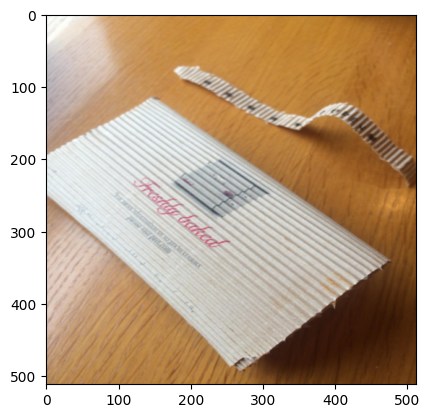

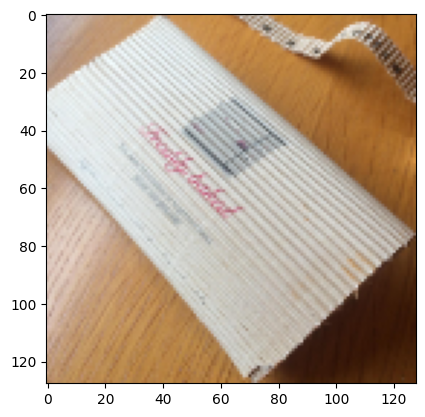

In [12]:
Data = DataLoader(WasteDatasetImages(img_size=512), batch_size=32)
images, bboxes = next(iter(Data))
# raise Exception(len(images))
# print(images[0])
i = 1
plt.figure()
plt.imshow(plt_convert(images[i]))
plt.savefig(f'testing_{i}.png')
plt.figure()
plt.imshow(plt_convert(crop_img(images[i],bboxes[i])))
plt.savefig(f'testing2_{i}.png')
selective_search(images[i:i+1])###################


In [ ]:
    # DATA_PATH = "/dtu/datasets1/02514/data_wastedetection"
    # output_dir = "output_images"
    # os.makedirs(output_dir, exist_ok=True)

    # resize_dims = (512, 512)
    # dataset = WasteDatasetImages(transform=transforms.ToTensor(), resize=resize_dims)
    # dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    # print(dataloader)

    # num_images_to_process = 10
    # for idx, (image, bboxes) in enumerate(dataloader):
    #     if idx >= num_images_to_process:
    #         break

    #     img = image.squeeze().permute(1, 2, 0).numpy()

    #     fig, ax = plt.subplots()
    #     ax.imshow(img)

    #     for bbox in bboxes:
    #         bbox = [item.item() for item in bbox]
    #         print(f"Bounding box: {bbox}")

    #         x, y, width, height = bbox
    #         rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    #         ax.add_patch(rect)

    #     output_path = os.path.join(output_dir, f"image_{idx}.jpg")
    #     plt.savefig(output_path)
    #     plt.close(fig)

    #     print(f"Processed image {idx + 1}/{len(dataloader)}")

    # print("Images with bounding boxes saved.")

    # # ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # # num_images_to_process = 2

    # # for idx, image in enumerate(dataloader):
    # #     if idx >= num_images_to_process:
    # #         break

    # #     print(f"Processing image {idx + 1}/{num_images_to_process}")

    # #     # Convert image from tensor to numpy array
    # #     img = image.squeeze().permute(1, 2, 0).numpy()
    # #     img = (img * 255).astype(np.uint8)  # Convert to uint8

    # #     ss.setBaseImage(img)
    # #     ss.switchToSelectiveSearchFast()
    # #     rects = ss.process()
    # #     print(f"Number of regions: {len(rects)}")
    # #     print(f"Regions: {rects}")

    #     img_with_regions = img.copy()
    #     for i, (x, y, w, h) in enumerate(rects):
    #         cv2.rectangle(img_with_regions, (x, y), (x + w, y + h), (0, 255, 0), 2)

    #     output_path = os.path.join(output_dir, f"image_{idx}.jpg")
    #     cv2.imwrite(output_path, img_with_regions)

    #     num_rects = len(rects)
    #     print(f"Processed image {idx + 1}/{num_images_to_process}")
    #     print(f"Number of rectangles: {num_rects}")

    # print("Selective search completed.")